# Imports, install and mount

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# import sys
# my_local_drive='/content/gdrive/MyDrive/SL2024/datas'
# # Ajout du path pour les librairies, fonctions et données
# sys.path.append(my_local_drive)
# # Se positionner sur le répertoire associé
# %cd $my_local_drive
# %pwd
# print("DRIVE MOUNTED")

In [2]:
! pip install cuda
! pip install torch_geometric
! pip install dgl

import torch
import torch.optim as optim
import os.path as osp
from torch_geometric.datasets import FB15k_237
from torch_geometric.nn import ComplEx
from torch_geometric.data import Data
import pandas as pd
from tqdm import tqdm
from torch_geometric.loader import DataLoader
import dgl
import os


Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement cuda (from versions: none)
ERROR: No matching distribution found for cuda
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.2.0) or chardet (5.2.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/home/elliot/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu' # Tip : Use cpu for debugging
print(device)

cuda


# TSV to pyg.Data

We want :
- x (tensorised and processed node attributes) (1 for now)
- edge_index (a tensor of shape (num_edges, 2) indicates the source node index and the destination node index)
- edge_attr (a tensor that indicate the type of each edge)
- y (edge labels - optional, can be defined as node labels if needed)

## Reading and mapping graph

What we want : Create a Data object with all the properties I want to use later

	- x (tensorised and processed node attributes) (Not for now)
	- edge_index (a tensor of shape (num_edges, 2) indicates the source node index and the destination node index)
	- y (desired edge labels - optional, can be defined as node labels if needed) (Not for now)
	- any other things you want to use later

In [4]:
file_path = "/home/elliot/Desktop/StageM2/data/iric/little_iric.tsv"
iric = pd.read_csv(file_path, delimiter='\t')
display(iric)

# Mapping entities to ids

entity_set = set(iric['object']).union(set(iric['subject']))
entity_to_mapping = {entity: i for i, entity in enumerate(entity_set)}
relation_set = set(iric['predicate'])
relation_to_mapping = {relation: i for i, relation in enumerate(relation_set)}

mapped_iric = iric.copy()
mapped_iric['object'] = mapped_iric['object'].apply(lambda x: entity_to_mapping[x])
mapped_iric['subject'] = mapped_iric['subject'].apply(lambda x: entity_to_mapping[x])
mapped_iric['predicate'] = mapped_iric['predicate'].apply(lambda x: relation_to_mapping[x])

display(mapped_iric)


print("Minima in mappings :")
print('subject :', min(mapped_iric['subject']))
print('predicate :',min(mapped_iric['predicate']))
print('object :',min(mapped_iric['object']))

print(entity_to_mapping)
print(relation_to_mapping)

mapping_to_entity = {v: k for k, v in entity_to_mapping.items()}
mapping_to_relation = {v: k for k, v in relation_to_mapping.items()}
print(mapping_to_entity)
print(mapping_to_relation)

,subject,predicate,object
0,GO:0000001,is_a,GO:0048311
1,GO:0000001,is_a,GO:0048308
2,GO:0000002,is_a,GO:0007005
3,GO:0000003,is_a,GO:0008150
4,GO:0000006,is_a,GO:0005385
...,...,...,...
9994,GO:0009920,is_a,GO:0000919
9995,GO:0009920,is_a,GO:1903047
9996,GO:0009921,is_a,GO:0098797
9997,GO:0009922,is_a,GO:0016747


,subject,predicate,object
0,1145,0,6309
1,1145,0,430
2,2755,0,488
3,6285,0,6342
4,1110,0,8691
...,...,...,...
9994,2039,0,5163
9995,2039,0,3120
9996,8211,0,8207
9997,1997,0,5638


Minima in mappings :
subject : 0
predicate : 0
object : 2
{'GO:0009625': 0, 'GO:0005980': 1, 'GO:0005221': 2, 'GO:0042573': 3, 'GO:0019766': 4, 'GO:0006931': 5, 'GO:0043114': 6, 'GO:0001839': 7, 'GO:1901618': 8, 'GO:0000450': 9, 'GO:0009700': 10, 'GO:0010333': 11, 'GO:0004103': 12, 'GO:0005704': 13, 'GO:0019136': 14, 'GO:0008986': 15, 'GO:0005358': 16, 'GO:0072523': 17, 'GO:0006996': 18, 'GO:0003169': 19, 'GO:0019988': 20, 'GO:0008805': 21, 'GO:0072164': 22, 'GO:0004998': 23, 'GO:0160041': 24, 'GO:0000953': 25, 'GO:0002892': 26, 'GO:0009027': 27, 'GO:0002089': 28, 'GO:0002054': 29, 'GO:0004515': 30, 'GO:0006367': 31, 'GO:0006777': 32, 'GO:0005834': 33, 'GO:0009215': 34, 'GO:0003836': 35, 'GO:0004968': 36, 'GO:0004035': 37, 'GO:0006370': 38, 'GO:0006701': 39, 'GO:0046114': 40, 'GO:0001515': 41, 'GO:0005174': 42, 'GO:0070569': 43, 'GO:1901136': 44, 'GO:0004598': 45, 'GO:0000923': 46, 'GO:0000833': 47, 'GO:0046038': 48, 'GO:0005169': 49, 'GO:0002583': 50, 'GO:0009568': 51, 'GO:0042119': 5

## Building init vars for Data :

In [5]:
# # Initial nodes states :
# x = torch.ones(len(entity_set), 1)  # Chaque nœud a 1 pour état initial
# print('X : \n',x)

# Edges index
heads = list(mapped_iric['subject'])
tails = list(mapped_iric['object'])
edge_index = torch.tensor([heads,tails], dtype=torch.long)
print('\nEDGE INDEX : \n',edge_index)

# edges states
edge_attributes = torch.tensor(mapped_iric['predicate'])
print('\nEDGES ATTRIBUTES : \n',edge_attributes)

iric_pyg = Data(
                # x = x,
                num_nodes = len(entity_set),
                edge_index = edge_index,
                edge_attr = edge_attributes)
print('\nDATASET :\n',iric_pyg)


print("\nDataset looks valid ? \n",iric_pyg.validate(raise_on_error=True))


EDGE INDEX : 
 tensor([[1145, 1145, 2755,  ..., 8211, 1997, 7704],
        [6309,  430,  488,  ..., 8207, 5638, 5462]])

EDGES ATTRIBUTES : 
 tensor([0, 0, 0,  ..., 0, 0, 0])

DATASET :
 Data(edge_index=[2, 9999], edge_attr=[9999], num_nodes=8859)

Dataset looks valid ? 
 True


# Setting up datas and model


## Splitting dataset

In [6]:
from torch_geometric.transforms import RandomLinkSplit

transform = RandomLinkSplit(
                            num_val = 0.1,
                            num_test = 0.1,
                            is_undirected=False,
                            add_negative_train_samples=False,
                            )

train_data, val_data, test_data = transform(iric_pyg)

print(f"Hole Dataset :\n {iric_pyg}\n\nTrain:\n{train_data}\n\nTest :\n{test_data}\n\nValidation :\n{val_data}")
# Il ne faut pas regarder num_edges parce que RLS cache les arêtes mais ne les sort pas du graph.
# print(f"Number of edges in datasets : \n  Hole Dataset : {iric_pyg.num_edges}\n\n  Train: {train_data.num_edges}\n\n  Test : {test_data.num_edges}\n\n  Validation : {val_data.num_edges}")
print(f"Number of edges in datasets : \n  Train: {list(train_data.edge_label.size())[0]}\n\n  Test : {list(test_data.edge_label.size())[0]}\n\n  Validation : {list(val_data.edge_label.size())[0]}")

train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)

print('\n\n',train_data.num_nodes)
print(train_data.num_edge_types)
print(train_data.__dict__)
print(train_data.edge_index[0].size())
print(train_data.edge_index[1].size())
print(train_data.edge_attr.size())
print(train_data.edge_attr)
print(train_data.num_nodes)
print(train_data.edge_index.size()[1])

Hole Dataset :
 Data(edge_index=[2, 9999], edge_attr=[9999], num_nodes=8859)

Train:
Data(edge_index=[2, 8001], edge_attr=[8001], num_nodes=8859, edge_label=[8001], edge_label_index=[2, 8001])

Test :
Data(edge_index=[2, 9000], edge_attr=[9000], num_nodes=8859, edge_label=[1998], edge_label_index=[2, 1998])

Validation :
Data(edge_index=[2, 8001], edge_attr=[8001], num_nodes=8859, edge_label=[1998], edge_label_index=[2, 1998])
Number of edges in datasets : 
  Train: 8001

  Test : 1998

  Validation : 1998


 8859
1
{'_edge_attr_cls': <class 'torch_geometric.data.data.DataEdgeAttr'>, '_tensor_attr_cls': <class 'torch_geometric.data.data.DataTensorAttr'>, '_store': {'edge_index': tensor([[6051, 4576, 6159,  ..., 7642, 2671, 6045],
        [5816, 8387, 6390,  ..., 5068, 6671, 4425]], device='cuda:0'), 'edge_attr': tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0'), 'num_nodes': 8859, 'edge_label': tensor([1., 1., 1.,  ..., 1., 1., 1.], device='cuda:0'), 'edge_label_index': tensor([[6051, 

## Iniating model

In [7]:
hidden_channels = 30
batch_size = 4096

model = ComplEx(
    num_nodes=train_data.num_nodes,
    # num_relations=train_data.num_edge_types,
    num_relations = train_data.edge_index.size()[1],
    hidden_channels=hidden_channels,
).to(device)

head_index = train_data.edge_index[0]
tail_index = train_data.edge_index[1]
rel_type = train_data.edge_attr

loader = model.loader(
    head_index = head_index,
    tail_index = tail_index,
    rel_type = rel_type,
    batch_size=batch_size,
    shuffle=True,
    # neg_sampling = 4
)

optimizer = optim.Adam(model.parameters(),
                      #  lr=0.01, weight_decay=1e-6
                       )

# Training and testing ComplEx

In [8]:
@torch.no_grad()
def test(data):
    model.eval()
    return model.test(
        head_index=test_data.edge_index[0],
        tail_index=test_data.edge_index[1],
        rel_type=test_data.edge_attr,
        batch_size=1000,
        k=10,
    )

def train():
    model.train()
    total_loss = total_examples = 0

    for head_index, rel_type, tail_index in loader:
        optimizer.zero_grad()
        loss = model.loss(head_index, rel_type, tail_index)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * head_index.numel()
        total_examples += head_index.numel()
    return total_loss / total_examples

In [9]:
torch.set_grad_enabled(True)
model.to(device)

model.reset_parameters()


start_rank, start_mrr, start_hits_at_10 = test(test_data)
print(f'Start Test Mean Rank: {start_rank:.2f}, Start Test MRR: {start_mrr:.4f}, '
      f'Start Test Hits@10: {start_hits_at_10:.4f}')

losses = []
for epoch in range(1, 100):
    loss = train()
    losses.append(loss)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    if epoch % 500 == 0:
        rank, mrr, hits = test(val_data)
        print(f'Epoch: {epoch:03d}, Val Mean Rank: {rank:.2f}',
              f'Val MRR: {mrr:.4f}, Val Hits@10: {hits:.4f}')

rank, mrr, hits_at_10 = test(test_data)

print(f'Start Test Mean Rank: {start_rank:.2f}, Start Test MRR: {start_mrr:.4f}, '
      f'Start Test Hits@10: {start_hits_at_10:.4f}')
print(f'Final Test Mean Rank: {rank:.2f}, Final Test MRR: {mrr:.4f}, '
      f'Final Test Hits@10: {hits_at_10:.4f}')

torch.set_grad_enabled(False)

  0%|          | 0/9000 [00:00<?, ?it/s]

100%|██████████| 9000/9000 [00:30<00:00, 295.19it/s]


Start Test Mean Rank: 4431.15, Start Test MRR: 0.0011, Start Test Hits@10: 0.0017
Epoch: 001, Loss: 0.6931
Epoch: 002, Loss: 0.6931
Epoch: 003, Loss: 0.6931
Epoch: 004, Loss: 0.6931
Epoch: 005, Loss: 0.6931
Epoch: 006, Loss: 0.6931
Epoch: 007, Loss: 0.6931
Epoch: 008, Loss: 0.6931
Epoch: 009, Loss: 0.6931
Epoch: 010, Loss: 0.6931
Epoch: 011, Loss: 0.6930
Epoch: 012, Loss: 0.6930
Epoch: 013, Loss: 0.6930
Epoch: 014, Loss: 0.6930
Epoch: 015, Loss: 0.6929
Epoch: 016, Loss: 0.6929
Epoch: 017, Loss: 0.6928
Epoch: 018, Loss: 0.6928
Epoch: 019, Loss: 0.6927
Epoch: 020, Loss: 0.6926
Epoch: 021, Loss: 0.6925
Epoch: 022, Loss: 0.6924
Epoch: 023, Loss: 0.6923
Epoch: 024, Loss: 0.6922
Epoch: 025, Loss: 0.6920
Epoch: 026, Loss: 0.6918
Epoch: 027, Loss: 0.6916
Epoch: 028, Loss: 0.6914
Epoch: 029, Loss: 0.6912
Epoch: 030, Loss: 0.6909
Epoch: 031, Loss: 0.6906
Epoch: 032, Loss: 0.6903
Epoch: 033, Loss: 0.6899
Epoch: 034, Loss: 0.6895
Epoch: 035, Loss: 0.6891
Epoch: 036, Loss: 0.6886
Epoch: 037, Loss: 

100%|██████████| 9000/9000 [00:30<00:00, 295.38it/s]

Start Test Mean Rank: 4431.15, Start Test MRR: 0.0011, Start Test Hits@10: 0.0017
Final Test Mean Rank: 395.98, Final Test MRR: 0.7533, Final Test Hits@10: 0.8994


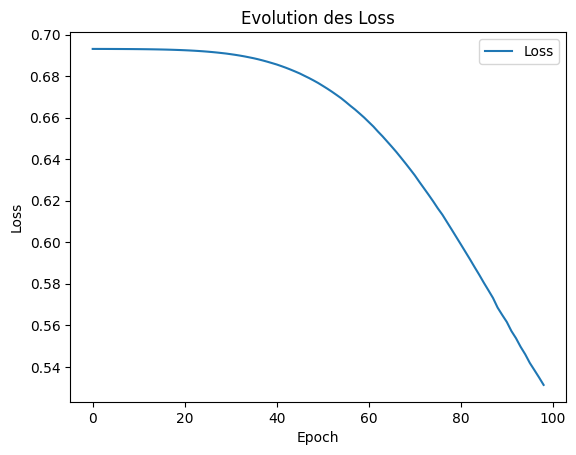

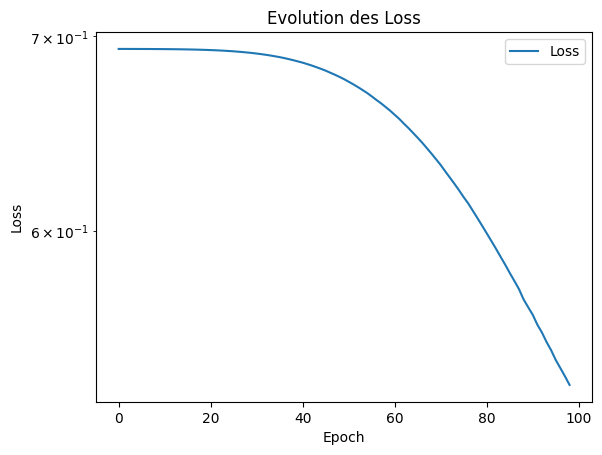

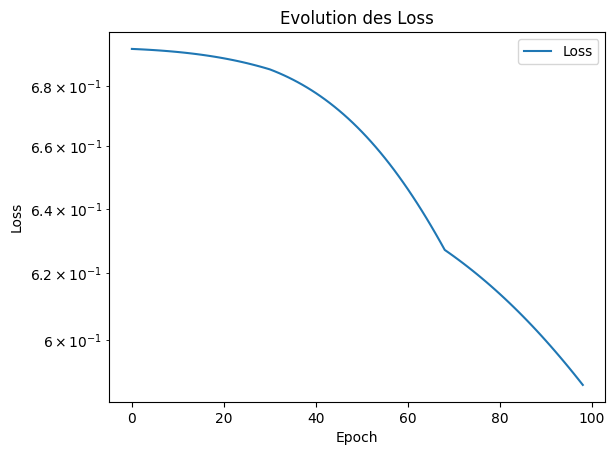

In [10]:
import matplotlib.pyplot as plt
def plot_loss(loss_list):
    plt.plot(loss_list, label='Loss')
    plt.title('Evolution des Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_loss_log(loss_list):
    plt.semilogy(loss_list, label='Loss')
    plt.title('Evolution des Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def running_mean(list,
                 half_window: int # Number of elements that the function will consider 
                                  # ahead and behind the pos X to calculate running mean at X.
                 ):

    running_means = []

    for i in range(0,len(list)):

        left_bound = max(0,i-half_window)
        right_bound = min(len(list)-1, i + half_window)
        sublist = list[left_bound:right_bound+1]
        running_means.append(sum(sublist)/len(sublist))

    return running_means

plot_loss(losses)
plot_loss_log(losses)
plot_loss_log(running_mean(losses, 30))

# Looking for embeddings

In [11]:
model_save_path = "TestComplEx"
loc_path = %pwd
torch.save(model.state_dict(), model_save_path)
print(f'Model saved at {loc_path}/{model_save_path}')

Model saved at /home/elliot/Desktop/StageM2/ESL2024/code/TestComplEx


In [12]:
model.to('cpu')
torch.set_grad_enabled(False)

# Is model coherent ?
iric_first_line = iric.iloc[0].tolist()
map_tail = entity_to_mapping[iric_first_line[0]]
map_head = entity_to_mapping[iric_first_line[2]]
map_rel = relation_to_mapping[iric_first_line[1]]

print("Good score should appear here :")
print(model(torch.tensor(map_tail),torch.tensor(map_rel),torch.tensor(map_head)))

print("Bad scores should appear here :")
print(model(torch.tensor(3307),torch.tensor(0),torch.tensor(4788)))
print(model(torch.tensor(3307),torch.tensor(0),torch.tensor(4378)))

Good score should appear here :
tensor(0.0034)
Bad scores should appear here :
tensor(-0.0526)
tensor(0.0314)


Attributs pour accéder aux embeddings :

        head_re = self.node_emb(head_index)
        head_im = self.node_emb_im(head_index)
        rel_re = self.rel_emb(rel_type)
        rel_im = self.rel_emb_im(rel_type)
        tail_re = self.node_emb(tail_index)
        tail_im = self.node_emb_im(tail_index)

In [13]:
entities_mapping_to_embedding = {}
relation_mapping_to_embedding = {}

for entity in entity_set:
    entity_id = entity_to_mapping[entity]

    real_part = model.node_emb(torch.tensor(entity_id))
    im_part = model.node_emb_im(torch.tensor(entity_id))

    embedding = torch.cat((real_part, im_part))

    entities_mapping_to_embedding[entity_id] = embedding

for relation in relation_set:
    relation_id = relation_to_mapping[relation]

    real_part = model.rel_emb(torch.tensor(relation_id))
    im_part = model.rel_emb_im(torch.tensor(relation_id))

    embedding = torch.cat((real_part, im_part))

    relation_mapping_to_embedding[relation_id] = embedding

In [14]:
print(relation_mapping_to_embedding[0])
print(entities_mapping_to_embedding[0])

tensor([-0.3497, -0.3559,  0.3510, -0.3508, -0.3516,  0.3396, -0.3438, -0.3534,
         0.3509,  0.3556, -0.3443, -0.3576,  0.3603,  0.3457, -0.3519,  0.3622,
        -0.3515,  0.3631,  0.3478,  0.3546, -0.3415, -0.3478, -0.3529, -0.3495,
         0.3503,  0.3466, -0.3426,  0.3552, -0.3540, -0.3378,  0.3541,  0.3455,
        -0.3482, -0.3559, -0.3553,  0.3551, -0.3506,  0.3532,  0.3420,  0.3487,
        -0.3598,  0.3573, -0.3610,  0.3462, -0.3570, -0.3550, -0.3543, -0.3614,
         0.3559, -0.3496,  0.3382, -0.3571,  0.3474,  0.3469, -0.3507,  0.3485,
        -0.3537,  0.3572, -0.3478, -0.3450])
tensor([ 0.1351, -0.1926, -0.0037, -0.0289, -0.1772, -0.0595,  0.1028, -0.1812,
        -0.1758,  0.0587,  0.0498,  0.1723, -0.0629, -0.0623, -0.1561, -0.0320,
         0.1978,  0.1669, -0.2088, -0.1819, -0.0778,  0.1139, -0.1933,  0.0783,
        -0.1690,  0.0656, -0.1857, -0.0172,  0.1932, -0.0343,  0.1472,  0.1143,
        -0.1485,  0.1522, -0.0065, -0.2115,  0.1151, -0.1329,  0.0537, -0.1

# Preparing a dataset to investigate modified loss

## Making negative triples

On va créer n triplets négatifs par triplet positif.
Pour créer un triplet négatif à partir d'un triplet positif, on remplace la tête de ce dernier par une entité aléatoire.
Il y a une chance de créer des faux négatifs, mais comme chaque entité apparait moins d'une fois sur 1000 dans le jeu de données, cette probabilité reste faible.

In [15]:
# Nombre de triplets négatif par triplet positif :
n_negative_triplets_per_positive = 5

In [16]:
# Nombre d'apparition de chaque entité dans iric :
# mapped_iric.hist(column="subject", bins = len(list(entity_set)))

In [17]:
import numpy as np
from tqdm import tqdm
import random

def generate_negative_triples(df, number_of_false_per_true, falsify_relation = False):


    negative_triples = []

    possible_heads = list(set(list(df.iloc[:,0])))
    possible_relations = list(set(list(df.iloc[:,1])))
    possible_tails = list(set(list(df.iloc[:,2])))

    for index, row in tqdm(df.iterrows(), total=len(df), desc="Generating Negative Triples"):
        for i in range(number_of_false_per_true):

            if falsify_relation :
                r = np.random.randint(2) 
            else :
                r = np.random.randint(3)

            if r == 0:
                random_head = random.choice(possible_heads)
                negative_triples.append([random_head, row[1], row[2]])

            elif r == 1:
                random_tail = random.choice(possible_tails)
                negative_triples.append([row[0], row[1], random_tail])

            elif r == 2:
                random_relation = random.choice(possible_relations)
                negative_triples.append([row[0], random_relation, row[2]])
    negative_triples_df = pd.DataFrame(negative_triples, columns=df.columns)
    return pd.DataFrame(negative_triples_df)

negatives_from_iric = generate_negative_triples(mapped_iric, n_negative_triplets_per_positive)

display(mapped_iric)
display(negatives_from_iric)

Generating Negative Triples:   0%|          | 0/9999 [00:00<?, ?it/s]

/tmp/ipykernel_170494/438568946.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  negative_triples.append([row[0], random_relation, row[2]])
/tmp/ipykernel_170494/438568946.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  negative_triples.append([random_head, row[1], row[2]])
/tmp/ipykernel_170494/438568946.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  negative_triples.append([row[0], row[1], random_tail])
Generating N

,subject,predicate,object
0,1145,0,6309
1,1145,0,430
2,2755,0,488
3,6285,0,6342
4,1110,0,8691
...,...,...,...
9994,2039,0,5163
9995,2039,0,3120
9996,8211,0,8207
9997,1997,0,5638


,subject,predicate,object
0,1145,0,6309
1,6848,0,6309
2,3257,0,6309
3,1145,0,6309
4,1145,0,6664
...,...,...,...
49990,7704,0,865
49991,869,0,5462
49992,2189,0,5462
49993,7704,0,5462


In [19]:
labelled_mapped_iric = mapped_iric.copy()
labelled_mapped_iric['label']=1
labelled_negatives_from_iric = negatives_from_iric.copy()
labelled_negatives_from_iric['label']=0
mapped_iric_with_negatives = pd.concat([labelled_mapped_iric, labelled_negatives_from_iric])
display(mapped_iric_with_negatives)

,subject,predicate,object,label
0,1145,0,6309,1
1,1145,0,430,1
2,2755,0,488,1
3,6285,0,6342,1
4,1110,0,8691,1
...,...,...,...,...
49990,7704,0,865,0
49991,869,0,5462,0
49992,2189,0,5462,0
49993,7704,0,5462,0


In [24]:
shuffled_mapped_iric_with_negatives = mapped_iric_with_negatives.sample(frac=1).reset_index(drop=True)
display(shuffled_mapped_iric_with_negatives)

,subject,predicate,object,label
0,447,0,589,0
1,1305,0,7929,0
2,6654,0,7969,1
3,4179,0,6233,0
4,465,0,5964,1
...,...,...,...,...
59989,1441,0,6662,0
59990,2014,0,4720,0
59991,7427,0,3626,0
59992,3063,0,5332,0


## From mapping to embedding

In [25]:
display(shuffled_mapped_iric_with_negatives)

tensorized_triples = shuffled_mapped_iric_with_negatives.copy()
tensorized_triples['object'] = tensorized_triples['object'].apply(lambda x: entities_mapping_to_embedding[x])
tensorized_triples['subject'] = tensorized_triples['subject'].apply(lambda x: entities_mapping_to_embedding[x])
tensorized_triples['predicate'] = tensorized_triples['predicate'].apply(lambda x: relation_mapping_to_embedding[x])

display(tensorized_triples)

,subject,predicate,object,label
0,447,0,589,0
1,1305,0,7929,0
2,6654,0,7969,1
3,4179,0,6233,0
4,465,0,5964,1
...,...,...,...,...
59989,1441,0,6662,0
59990,2014,0,4720,0
59991,7427,0,3626,0
59992,3063,0,5332,0


,subject,predicate,object,label
0,"[tensor(0.0139), tensor(0.0052), tensor(-0.034...","[tensor(-0.3497), tensor(-0.3559), tensor(0.35...","[tensor(0.0004), tensor(0.0273), tensor(-0.039...",0
1,"[tensor(-0.1985), tensor(0.2218), tensor(-0.01...","[tensor(-0.3497), tensor(-0.3559), tensor(0.35...","[tensor(0.2643), tensor(-0.1875), tensor(-0.22...",0
2,"[tensor(-0.1905), tensor(0.2132), tensor(0.166...","[tensor(-0.3497), tensor(-0.3559), tensor(0.35...","[tensor(-0.0041), tensor(-0.2801), tensor(-0.1...",1
3,"[tensor(0.1414), tensor(-0.0075), tensor(0.146...","[tensor(-0.3497), tensor(-0.3559), tensor(0.35...","[tensor(0.0423), tensor(-0.2746), tensor(0.319...",0
4,"[tensor(0.0818), tensor(0.2330), tensor(0.2015...","[tensor(-0.3497), tensor(-0.3559), tensor(0.35...","[tensor(-0.0924), tensor(-0.2511), tensor(0.21...",1
...,...,...,...,...
59989,"[tensor(0.0192), tensor(-0.0105), tensor(0.009...","[tensor(-0.3497), tensor(-0.3559), tensor(0.35...","[tensor(-0.0063), tensor(0.0103), tensor(0.004...",0
59990,"[tensor(-0.1441), tensor(-0.0376), tensor(-0.0...","[tensor(-0.3497), tensor(-0.3559), tensor(0.35...","[tensor(0.2343), tensor(0.2660), tensor(-0.255...",0
59991,"[tensor(0.2086), tensor(0.0379), tensor(0.0497...","[tensor(-0.3497), tensor(-0.3559), tensor(0.35...","[tensor(0.0267), tensor(-0.2626), tensor(-0.21...",0
59992,"[tensor(0.2046), tensor(0.0484), tensor(0.0237...","[tensor(-0.3497), tensor(-0.3559), tensor(0.35...","[tensor(-0.3312), tensor(0.3196), tensor(0.279...",0


In [33]:
x_y_couples = []

dataset = tensorized_triples.apply(lambda row: pd.Series({'x': torch.cat([row[0], row[1], row[2]]), 'y': row[3]}), axis=1)
display(dataset)


/tmp/ipykernel_170494/1796629091.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dataset = tensorized_triples.apply(lambda row: pd.Series({'x': torch.cat([row[0], row[1], row[2]]), 'y': row[3]}), axis=1)


,x,y
0,"[tensor(0.0139), tensor(0.0052), tensor(-0.034...",0
1,"[tensor(-0.1985), tensor(0.2218), tensor(-0.01...",0
2,"[tensor(-0.1905), tensor(0.2132), tensor(0.166...",1
3,"[tensor(0.1414), tensor(-0.0075), tensor(0.146...",0
4,"[tensor(0.0818), tensor(0.2330), tensor(0.2015...",1
...,...,...
59989,"[tensor(0.0192), tensor(-0.0105), tensor(0.009...",0
59990,"[tensor(-0.1441), tensor(-0.0376), tensor(-0.0...",0
59991,"[tensor(0.2086), tensor(0.0379), tensor(0.0497...",0
59992,"[tensor(0.2046), tensor(0.0484), tensor(0.0237...",0


In [34]:
print(dataset['x'][0])

tensor([ 1.3920e-02,  5.2462e-03, -3.4472e-02, -1.0107e-03,  2.7667e-02,
         7.9977e-04, -2.5365e-02, -3.0868e-02, -2.1353e-02, -1.4446e-02,
        -2.8069e-02,  2.1060e-03, -2.9561e-02, -1.7345e-02, -1.3169e-02,
         7.4472e-02,  1.1198e-03, -8.3466e-03,  1.8001e-02, -1.8518e-03,
         3.0894e-02, -5.3456e-02,  1.5366e-02, -2.4376e-02, -5.0356e-03,
        -2.0717e-02,  1.0549e-02,  1.4814e-02,  4.8353e-03,  2.0245e-02,
         3.6587e-02,  2.0448e-02, -2.1771e-02,  4.0683e-02, -3.1461e-02,
         3.2396e-02, -2.3829e-02, -4.1523e-02,  1.8009e-02,  8.2853e-03,
        -2.3141e-02,  8.5344e-03,  5.8172e-02,  2.4797e-02,  1.0770e-02,
         3.8986e-02, -8.5548e-03,  8.3687e-03,  1.9627e-02,  4.5549e-02,
         6.1329e-03, -1.7543e-02, -3.3135e-02,  2.8338e-02,  1.9461e-02,
         3.3909e-02,  1.9018e-02,  5.6405e-02, -5.1108e-03, -1.3725e-02,
        -3.4971e-01, -3.5587e-01,  3.5105e-01, -3.5081e-01, -3.5163e-01,
         3.3959e-01, -3.4378e-01, -3.5338e-01,  3.5